### UTS Penambangan Data  

Anggota Kelompok 8 : 
1. Harisya Miranti  
2. Shafa Aulia  
3. Elma Nurul Fatika

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process

c:\Users\ASUS\miniconda3\envs\myenv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Membaca dataset dan Pemeriksaan awal dataset
df = pd.read_csv("pembelian.csv", sep=';', encoding='utf-8')
print("Ukuran dataset:", df.shape)
display(df.head())
print(df.dtypes)

Ukuran dataset: (138364, 8)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_32392\2259836403.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("pembelian.csv", sep=';', encoding='utf-8')


,kode,nama product,unit,tgl transaksi,kode transaksi,kategori,qty,nilai
0,A000001,ANATON TAB,STRIP,06-07-21,1.13-210706.0908-003,Masuk,10,2520
1,A000001,ANATON TAB,STRIP,12-07-21,2.6-210712.1519-097,Keluar,1,3000
2,A000001,ANATON TAB,STRIP,12-07-21,2.11-210712.1633-013,Keluar,1,3000
3,A000001,ANATON TAB,STRIP,12-07-21,2.13-210712.1807-013,Keluar,1,3000
4,A000001,ANATON TAB,STRIP,12-07-21,2.11-210712.1855-018,Keluar,1,3000


kode              object
nama product      object
unit              object
tgl transaksi     object
kode transaksi    object
kategori          object
qty               object
nilai             object
dtype: object


In [3]:
# Cek jumlah nilai null tiap kolom
print(df.isna().sum())

kode              0
nama product      0
unit              0
tgl transaksi     0
kode transaksi    0
kategori          0
qty               0
nilai             0
dtype: int64


In [4]:
# Normalisasi kolom penting 
for c in ['kode','nama product','unit','kode transaksi','kategori','tgl transaksi']:
    df[c] = df[c].astype(str).str.strip()

# Normalisasi angka 'nilai' jika memakai koma sebagai desimal 
# Coba konversi aman:
def parse_number(x):
    try:
        # replace thousands dot and comma decimal (common in datasetmu)
        s = str(x).replace('.', '').replace(',', '.')
        return float(s)
    except:
        try:
            return float(x)
        except:
            return np.nan

df['nilai'] = df['nilai'].apply(parse_number)
df['qty'] = pd.to_numeric(df['qty'], errors='coerce')

# Parse tanggal (sesuaikan format, contoh '11-01-21')
df['tgl transaksi'] = pd.to_datetime(df['tgl transaksi'], dayfirst=True, errors='coerce')

display(df[['kode transaksi','kode','nama product','unit','qty','nilai','tgl transaksi']].head())
print("Missing nilai / qty / tgl:", df['nilai'].isna().sum(), df['qty'].isna().sum(), df['tgl transaksi'].isna().sum())


C:\Users\ASUS\AppData\Local\Temp\ipykernel_32392\2347100674.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tgl transaksi'] = pd.to_datetime(df['tgl transaksi'], dayfirst=True, errors='coerce')


,kode transaksi,kode,nama product,unit,qty,nilai,tgl transaksi
0,1.13-210706.0908-003,A000001,ANATON TAB,STRIP,10.0,2520.0,2021-07-06
1,2.6-210712.1519-097,A000001,ANATON TAB,STRIP,1.0,3000.0,2021-07-12
2,2.11-210712.1633-013,A000001,ANATON TAB,STRIP,1.0,3000.0,2021-07-12
3,2.13-210712.1807-013,A000001,ANATON TAB,STRIP,1.0,3000.0,2021-07-12
4,2.11-210712.1855-018,A000001,ANATON TAB,STRIP,1.0,3000.0,2021-07-12


Missing nilai / qty / tgl: 0 15 0


##### Exact Duplicate Detection
untuk deteksi baris yang memiliki kombinasi kode transaksi dan kode sama

In [5]:
# Exact Duplicate Detection
mask_exact = df.duplicated(subset=['kode transaksi','kode'], keep=False)
df_exact_duplicates = df[mask_exact].sort_values(['kode transaksi','kode'])
print("Jumlah baris yang terlibat dalam exact-duplicate (kombinasi):", len(df_exact_duplicates))
display(df_exact_duplicates.head(10))
# Agregasi: hitung kombinasi transaksi-produk yang muncul >1
dupe_counts = df_exact_duplicates.groupby(['kode transaksi','kode']).size().reset_index(name='jumlah_duplikat')
dupe_counts_summary = dupe_counts['jumlah_duplikat'].value_counts().sort_index()
print("Distribusi jumlah duplikat per kombinasi:\n", dupe_counts_summary)


Jumlah baris yang terlibat dalam exact-duplicate (kombinasi): 671


,kode,nama product,unit,tgl transaksi,kode transaksi,kategori,qty,nilai
107161,P0000253,PROSANA PROFILE COKLAT 60,PCS,2021-01-11,1.11-210111.0023-001,Masuk,6.0,10959.76
107168,P0000253,PROSANA PROFILE COKLAT 60,PCS,2021-01-11,1.11-210111.0023-001,Masuk,3.0,38318.28
76841,M0000078,MADU SYAMIL ANAK,BTL,2021-01-18,1.11-210118.1652-001,Masuk,2.0,16000.00
76916,M0000078,MADU SYAMIL ANAK,BTL,2021-01-18,1.11-210118.1652-001,Masuk,2.0,15000.00
57366,K0000006,KALPANAX KRIM,TUBE,2021-01-19,1.11-210119.0810-003,Masuk,3.0,11450.02
57367,K0000006,KALPANAX KRIM,TUBE,2021-01-19,1.11-210119.0810-003,Masuk,3.0,11450.02
41793,F000080,FITBES FORCE KAPLET,AMPLOP,2021-01-27,1.11-210127.0455-007,Masuk,1.0,0.00
41794,F000080,FITBES FORCE KAPLET,AMPLOP,2021-01-27,1.11-210127.0455-007,Masuk,6.0,12717.70
41871,F000085,FRESH CARE MKP,FLS,2021-01-27,1.11-210127.0455-007,Masuk,1.0,0.00
41872,F000085,FRESH CARE MKP,FLS,2021-01-27,1.11-210127.0455-007,Masuk,6.0,10810.04


Distribusi jumlah duplikat per kombinasi:
 jumlah_duplikat
2    296
3     17
4      3
5      2
6      1
Name: count, dtype: int64


##### Ekstrak kode cabang dari kode transaksi
kode cabang diekstraksi dari kode transaksi dimana digit awal diindikasi sebagai kode untuk cabang. 

In [6]:
# Contoh: ambil bagian sebelum '-' (sebelum pertama '-'), atau bagian sebelum titik
def extract_branch(kode_transaksi):
    s = str(kode_transaksi)
    # contoh format: "1.11-210111.0023-001"  branch_key = "1.11"
    if '-' in s:
        prefix = s.split('-',1)[0]
        return prefix
    else:
        return s

df['branch_key'] = df['kode transaksi'].apply(extract_branch)
display(df[['kode transaksi','branch_key']].drop_duplicates().head(10))


,kode transaksi,branch_key
0,1.13-210706.0908-003,1.13
1,2.6-210712.1519-097,2.6
2,2.11-210712.1633-013,2.11
3,2.13-210712.1807-013,2.13
4,2.11-210712.1855-018,2.11
5,2.11-210712.1925-027,2.11
6,2.11-210712.1957-035,2.11
7,2.6-210712.0907-023,2.6
8,2.11-210713.1102-011,2.11
9,2.6-210713.1701-006,2.6


##### Klasifikasi duplikat yang sah vs tidak sah

In [7]:
# Ambil kombinasi yang duplikat
dupe_combo = dupe_counts.copy()

# Untuk setiap kombinasi, cek jumlah branch_key unik
tmp = df.groupby(['kode transaksi','kode'])['branch_key'].nunique().reset_index(name='n_branch')
dupe_combo = dupe_combo.merge(tmp, on=['kode transaksi','kode'], how='left')

# Duplikat sah jika n_branch > 1 (ada perbedaan branch_key)
dupe_combo['is_sah'] = dupe_combo['n_branch'] > 1

print("Total kombinasi duplikat:", len(dupe_combo))
print("Jumlah kombinasi duplikat sah (branch berbeda):", dupe_combo['is_sah'].sum())
print("Jumlah kombinasi duplikat tidak sah:", (~dupe_combo['is_sah']).sum())

# Buat DataFrame baris untuk masing-masing jenis
dupe_sah = df.merge(dupe_combo[dupe_combo['is_sah']][['kode transaksi','kode']], on=['kode transaksi','kode'], how='inner')
dupe_tidak_sah = df.merge(dupe_combo[~dupe_combo['is_sah']][['kode transaksi','kode']], on=['kode transaksi','kode'], how='inner')

print("Baris duplikat sah:", len(dupe_sah), "Baris duplikat tidak sah:", len(dupe_tidak_sah))
display(dupe_tidak_sah.head(10))

Total kombinasi duplikat: 319
Jumlah kombinasi duplikat sah (branch berbeda): 0
Jumlah kombinasi duplikat tidak sah: 319
Baris duplikat sah: 0 Baris duplikat tidak sah: 671


,kode,nama product,unit,tgl transaksi,kode transaksi,kategori,qty,nilai,branch_key
0,A00003,ACTIVED MERAH,BTL,2021-02-03,1.11-210203.1313-008,Masuk,1.0,51986.17,1.11
1,A00003,ACTIVED MERAH,BTL,2021-02-03,1.11-210203.1313-008,Masuk,1.0,51986.17,1.11
2,A00019,AMLODIPINE 10MG,STRIP,2021-01-01,2.11-210101.1512-069,Keluar,1.0,12000.00,2.11
3,A00019,AMLODIPINE 10MG,STRIP,2021-01-01,2.11-210101.1512-069,Keluar,9.0,10000.00,2.11
4,A00019,AMLODIPINE 10MG,STRIP,2021-03-06,2.11-210306.1039-023,Keluar,1.0,12000.00,2.11
5,A00019,AMLODIPINE 10MG,STRIP,2021-03-06,2.11-210306.1039-023,Keluar,9.0,10000.00,2.11
6,A00020,AMLODIPINE 5MG,STRIP,2021-01-01,2.11-210101.1656-099,Keluar,1.0,6000.00,2.11
7,A00020,AMLODIPINE 5MG,STRIP,2021-01-01,2.11-210101.1656-099,Keluar,3.0,6000.00,2.11
8,A00020,AMLODIPINE 5MG,STRIP,2021-05-20,2.11-210520.1148-054,Keluar,1.0,6000.00,2.11
9,A00020,AMLODIPINE 5MG,STRIP,2021-05-20,2.11-210520.1148-054,Keluar,9.0,6000.00,2.11


In [8]:
# Untuk setiap kombinasi tidak sah, tampilkan ringkasan qty & nilai
summary_bad = (dupe_tidak_sah.groupby(['kode transaksi','kode'])
               .agg(jumlah_baris=('qty','size'),
                    qty_unique=('qty','nunique'),
                    nilai_unique=('nilai','nunique'),
                    qty_list=('qty',lambda x: list(x.unique())),
                    nilai_list=('nilai',lambda x: list(x.unique())))
               .reset_index()
               .sort_values('jumlah_baris', ascending=False))

display(summary_bad.head(10))


,kode transaksi,kode,jumlah_baris,qty_unique,nilai_unique,qty_list,nilai_list
127,1.11-211118.1107-007,B0000274,6,1,2,[1.0],"[0.0, 3025.89]"
61,1.11-210525.1510-003,M0000249,5,2,1,"[50.0, 100.0]",[1700.0]
211,1.13-210802.1936-006,S0000268,5,1,1,[1.0],[14851.68]
53,1.11-210510.1638-011,T0000063,4,4,1,"[5.0, 19.0, 24.0, 48.0]",[2637.5]
13,1.11-210204.1947-003,S0000076,4,1,1,[1.0],[13200.02]
96,1.11-210805.1839-005,A00177,4,1,1,[6.0],[4889.82]
84,1.11-210713.1544-005,C0000106,3,2,1,"[2.0, 3.0]",[11000.0]
93,1.11-210731.1217-001,L0000102,3,1,1,[6.0],[5280.0]
76,1.11-210629.1324-006,C0000106,3,1,1,[2.0],[11000.0]
55,1.11-210510.1648-013,P0000235,3,1,1,[6.0],[10230.17]


##### Melakukan pembersihan dataset yang duplikat dengan deleting data 

In [9]:
df_drop = df.drop_duplicates(subset=['kode transaksi','kode'], keep='first').reset_index(drop=True)
print("Ukuran setelah drop:", df_drop.shape)

Ukuran setelah drop: (138012, 9)


#### 1. Near-Duplicate Detection (Fuzzy) pada nama product   
untuk mendeteksi variansi nama produk yang sama.

In [10]:
# Ambil nama unik sampel (batasi jumlah jika banyak)
nama_unik = df['nama product'].dropna().unique()
len(nama_unik)  # lihat berapa unik

# Contoh: cari kemiripan untuk 50 nama pertama
sample_names = list(nama_unik[:200])  # sesuaikan ukuran

near_pairs = []
threshold = 85
for i, name in enumerate(sample_names):
    matches = process.extract(name, sample_names, scorer=fuzz.token_sort_ratio, limit=10)
    for m, score in matches:
        if m != name and score >= threshold:
            pair = tuple(sorted([name,m]))
            near_pairs.append((pair,score))
# unique pairs
near_pairs_unique = {}
for (pair,score) in near_pairs:
    near_pairs_unique[pair] = max(near_pairs_unique.get(pair,0), score)

# tampilkan beberapa pasangan
for i, (pair,score) in enumerate(sorted(near_pairs_unique.items(), key=lambda x:-x[1])[:20]):
    print(f"{i+1}. {pair[0]}  <-->  {pair[1]}  (score={score})")


1. BETADINE SOL 15 ML  <-->  BETADINE SOL 5 ML  (score=97)
2. ANAKONIDIN OBH 30ML  <-->  ANAKONIDIN OBH 60ML  (score=95)
3. BALSEM GELIGA 10 GR  <-->  BALSEM GELIGA 20 GR  (score=95)
4. BALSEM GELIGA 10 GR  <-->  BALSEM GELIGA 40 GR  (score=95)
5. BALSEM GELIGA 20 GR  <-->  BALSEM GELIGA 40 GR  (score=95)
6. BETADINE GARGLE 100ML  <-->  BETADINE GARGLE 190ML  (score=95)
7. ATORVASTATIN 10MG  <-->  ATORVASTATIN 20MG  (score=94)
8. ALKOHOL 70% 100ML  <-->  ALKOHOL 70% 300ML  (score=94)
9. ANAKONIDIN ME 30ML  <-->  ANAKONIDIN ME 60ML  (score=94)
10. BALSEM LANG 10 GR  <-->  BALSEM LANG 20 GR  (score=94)
11. BORRAGINOL N SUPPO  <-->  BORRAGINOL S SUPPO  (score=94)
12. ACYCLOVIR 200MG  <-->  ACYCLOVIR 400MG  (score=93)
13. BETASON CR 5G  <-->  BETASON N CR 5G  (score=93)
14. ALOFAR 100MG  <-->  ALOFAR 300MG  (score=92)
15. ANAKONIDIN 30ML  <-->  ANAKONIDIN ME 30ML  (score=91)
16. BETADINE OINT 10G  <-->  BETADINE OINT 5G  (score=91)
17. BETADINE SOL 30 ML  <-->  BETADINE SOL 5 ML  (score=91

ternyata rata rata produk merupakan produk yang sama dengan volume, variasi atau bahan aktif yang berbeda. jadi untuk fuzzy pada nama produk ini bukan karena typo hanya saja produk yang sama dengan isi atau variasi yang berbeda. 

#### Functional Dependency Analysis (bukti redundansi atribut)   
untuk menguji apakah kode → nama product dan kode → unit.

In [11]:
# kode -> nama product
cek_nama = df.groupby('kode')['nama product'].nunique().reset_index(name='n_nama')
print("Total kode:", len(cek_nama))
print("Kode dengan 1 nama:", (cek_nama['n_nama']==1).sum())
print("Persentase konsistensi (kode->nama):", ((cek_nama['n_nama']==1).mean()*100).round(2),"%")

# kode -> unit
cek_unit = df.groupby('kode')['unit'].nunique().reset_index(name='n_unit')
print("Persentase konsistensi (kode->unit):", ((cek_unit['n_unit']==1).mean()*100).round(2),"%")


Total kode: 1988
Kode dengan 1 nama: 1988
Persentase konsistensi (kode->nama): 100.0 %
Persentase konsistensi (kode->unit): 100.0 %


Semua kode hanya punya satu nama produk dan satu unit.
Maka, nama product dan unit secara fungsional tergantung pada kode.
Dengan demikian, kolom nama product dan unit redundan di tabel transaksi karena bisa di-lookup dari tabel master produk.


#### Visualisasi distribusi duplikasi + top problematic transactions

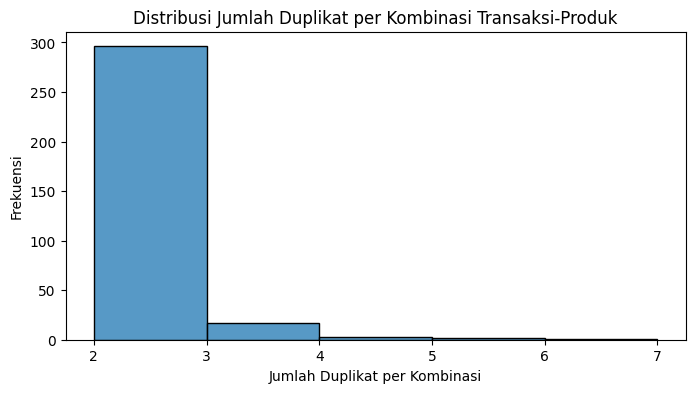

,kode transaksi,kode,jumlah_duplikat
6813,1.11-211118.1107-007,B0000274,6
2402,1.11-210525.1510-003,M0000249,5
12135,1.13-210802.1936-006,S0000268,5
2230,1.11-210510.1638-011,T0000063,4
667,1.11-210204.1947-003,S0000076,4


,kode,nama product,unit,tgl transaksi,kode transaksi,kategori,qty,nilai,branch_key
18768,B0000274,BELSOAP 65GR,PCS,2021-11-18,1.11-211118.1107-007,Masuk,1.0,0.00,1.11
18769,B0000274,BELSOAP 65GR,PCS,2021-11-18,1.11-211118.1107-007,Masuk,1.0,0.00,1.11
18770,B0000274,BELSOAP 65GR,PCS,2021-11-18,1.11-211118.1107-007,Masuk,1.0,0.00,1.11
18771,B0000274,BELSOAP 65GR,PCS,2021-11-18,1.11-211118.1107-007,Masuk,1.0,3025.89,1.11
18772,B0000274,BELSOAP 65GR,PCS,2021-11-18,1.11-211118.1107-007,Masuk,1.0,3025.89,1.11
18773,B0000274,BELSOAP 65GR,PCS,2021-11-18,1.11-211118.1107-007,Masuk,1.0,3025.89,1.11


In [12]:
# prepare dupe_counts (kombinasi)
dupe_counts = (df.groupby(['kode transaksi','kode']).size().reset_index(name='jumlah_duplikat'))
dupe_counts_more1 = dupe_counts[dupe_counts['jumlah_duplikat']>1]

plt.figure(figsize=(8,4))
sns.histplot(dupe_counts_more1['jumlah_duplikat'], bins=range(2,dupe_counts_more1['jumlah_duplikat'].max()+2))
plt.xlabel("Jumlah Duplikat per Kombinasi")
plt.ylabel("Frekuensi")
plt.title("Distribusi Jumlah Duplikat per Kombinasi Transaksi-Produk")
plt.show()

# Top 5 kombinasi paling duplikat
top5 = dupe_counts_more1.sort_values('jumlah_duplikat', ascending=False).head(5)
display(top5)
# show detail rows for top1
top1 = top5.iloc[0]
display(df[(df['kode transaksi']==top1['kode transaksi']) & (df['kode']==top1['kode'])].sort_values('qty'))


In [13]:
# Simpan hasil pembersihan
df_drop.to_csv("pembelian_clean_drop.csv", index=False, sep=';')